In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import dateparser


### scipy 
import numpy as np 
import pandas as pd
import xarray as xr
from scipy import stats as st
from cartopy import crs as ccrs

# dask 
from dask.diagnostics import ProgressBar

### plotting 
from matplotlib import pyplot as plt


In [3]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 


In [4]:
import sys

In [5]:
sys.path.append('../../')

In [6]:
domain = [125, 240, -35, 25]

In [7]:
from ICU_Water_Watch import plot, geo, utils, GPM

### directory with the daily GPM-IMERG data (one file per day )

In [8]:
dpath = pathlib.Path('/home/nicolasf/operational/ICU/ops/data/GPM_IMERG/daily/extended_SP')

In [9]:
lfiles = GPM.get_files_list(dpath=dpath)

In [10]:
lfiles[0]

PosixPath('/home/nicolasf/operational/ICU/ops/data/GPM_IMERG/daily/extended_SP/GPM_IMERG_daily.v06.2001.01.01.nc')

In [11]:
lfiles[-1]

PosixPath('/home/nicolasf/operational/ICU/ops/data/GPM_IMERG/daily/extended_SP/GPM_IMERG_daily.v06.2021.11.17.nc')

### open the multiple file dataset and selects the variable of interest 

In [12]:
dset = GPM.make_dataset(lfiles=lfiles)

### limit to the chosen day 

In [13]:
last_day = '2 days ago'

In [14]:
if last_day is not None: 
    last_day = dateparser.parse(last_day)
    dset = dset.sel(time=slice(None, f"{last_day:%Y-%m-%d}"))
else: 
    last_day = map(int, lfiles[-1].name.split(".")[-4:-1])
    last_day = datetime(*last_day)

### calculates the running accumulations 

### re-chunks first 

In [15]:
dset = dset.chunk({'time':-1, 'lon':10, 'lat':10})

### number of days 

In [16]:
ndays = 90

### running accumulation 

In [17]:
dset = dset.rolling({'time':ndays}, min_periods=ndays, center=False).sum('time')

In [18]:
with ProgressBar(): 
    dset = dset.compute()

[########################################] | 100% Completed | 52.5s


### get rid of the ndays - 1 first values (missing values)

In [19]:
dset = dset.isel(time=slice(ndays-1, None))

### buffer (in days) around the date (for taking the corresponding accumulations from the climatology)

In [20]:
buffer = 3

### climatological period 

In [21]:
clim_period =[2001, 2020]

## construct dates 

In [22]:
last_day

datetime.datetime(2021, 11, 17, 14, 20, 40, 590419)

In [23]:
clim = GPM.subset_daily_clim(dset, last_day, clim_period=clim_period)

In [24]:
alpha, beta = GPM.calibrate_SPI(clim)

In [25]:
dset_params = xr.Dataset()

In [26]:
dset_params['alpha'] = alpha

In [27]:
dset_params['beta'] = beta

In [28]:
dset_params

<xarray.Dataset>
Dimensions:  (lon: 460, lat: 300)
Coordinates:
  * lon      (lon) float64 125.1 125.4 125.6 125.9 ... 239.1 239.4 239.6 239.9
  * lat      (lat) float64 -49.88 -49.62 -49.38 -49.12 ... 24.38 24.62 24.88
Data variables:
    alpha    (lat, lon) float64 14.12 16.32 17.42 17.2 ... 1.26 1.242 1.241
    beta     (lat, lon) float64 20.56 18.05 17.14 17.42 ... 18.15 20.21 20.6

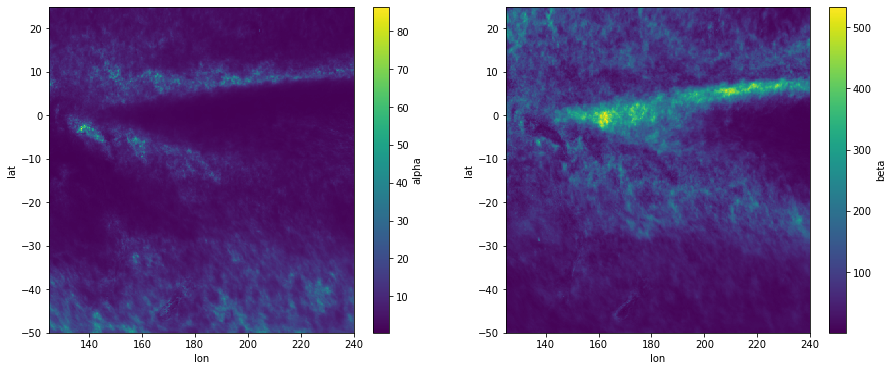

In [29]:
f, axes = plt.subplots(ncols=2, figsize=(15,6))
dset_params['alpha'].plot(ax=axes[0])
dset_params['beta'].plot(ax=axes[1])

In [30]:
norm_spi_realtime = GPM.calculate_SPI(dset['precipitationCal'].isel(time=-1), alpha, beta) 

### adds global attributes for number of days and last day in the dataset 

In [31]:
norm_spi_realtime = GPM.set_attrs(norm_spi_realtime, ndays=ndays, last_day=last_day)

### reads in the EEZs 

In [32]:
from ICU_Water_Watch import geo

In [33]:
EEZs, merged_EEZs = geo.get_EEZs(dpath_shapes='/home/nicolasf/operational/ICU/development/hotspots/data/shapefiles/')

### reads in the coastlines 

In [34]:
coastlines = geo.get_coastlines(dpath_shapes='/home/nicolasf/operational/ICU/development/hotspots/data/shapefiles/')

### adds the EEZ mask to the dataset 

In [35]:
norm_spi_realtime = geo.make_mask_from_gpd(norm_spi_realtime, merged_EEZs, subset=True, mask_name='EEZ')

In [36]:
from ICU_Water_Watch.plot import * 

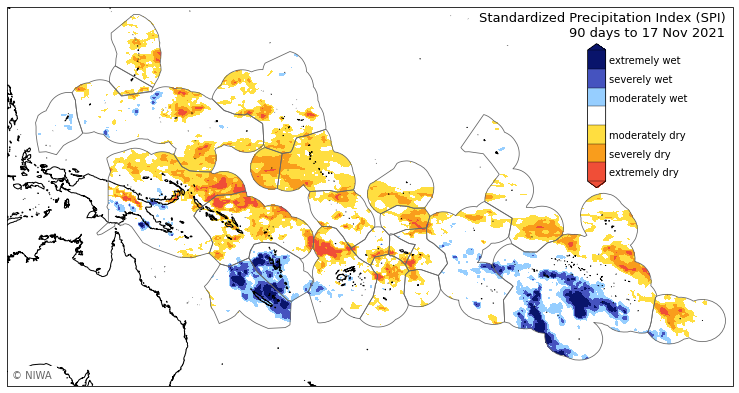

In [37]:
map_SPI_Pacific(norm_spi_realtime, mask='EEZ', geoms=EEZs, fpath='/home/nicolasf/Desktop/', close=False)

### Now produce a country level SPI 

In [38]:
country_name = 'Fiji'

In [39]:
print(f"   --> processing {country_name} for the SPI\n")

coastline = coastlines.query(f"country_na == '{country_name}'")

EEZ = EEZs.query(f"COUNTRYNAM == '{country_name}'")

   --> processing Fiji for the SPI



In [40]:
dset_sub_country = geo.make_mask_from_gpd(norm_spi_realtime, EEZ, subset=True, mask_name='mask_EEZ')

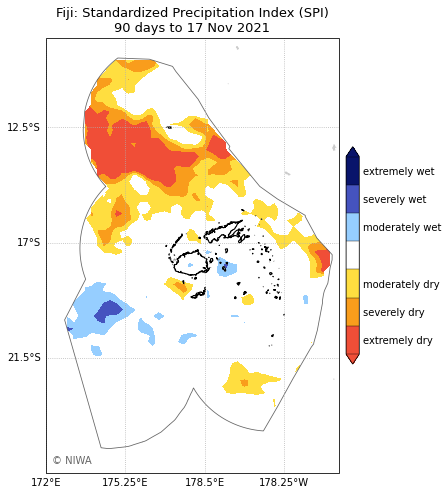

In [42]:
map_SPI(dset_sub_country, coastlines, coastline, EEZ, fpath='/home/nicolasf/Desktop/', close=False)